<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-1_FaceAlignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Alignment

## Выбор датасета

Датасет подготовлен в ноутбуке https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-1_PrepareDataset.ipynb . Сделаем класс для него

In [36]:
import pandas as pd
import torchvision.io as io
from PIL import Image # Импортируем PIL Image
import os # Импортируем os для операций с директориями кэша
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F_vision # Добавляем импорт для функциональных преобразований
import pandas as pd # Уже импортирован, но явный импорт лучше для самодостаточности ячейки
import numpy as np # Требуется для генерации карт тепла

lm = pd.read_csv('celeba_dataset/sm/translated_landmarks.csv', index_col='image_id')
lm

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000127.jpg,22,38,46,37,33,53,26,62,45,62
000160.jpg,55,90,115,100,76,140,49,156,99,164
000186.jpg,38,74,79,69,46,101,42,121,78,121
000248.jpg,30,47,59,44,47,60,37,81,62,78
000270.jpg,64,87,126,99,83,129,50,142,115,158
...,...,...,...,...,...,...,...,...,...,...
202502.jpg,56,84,110,83,88,118,63,146,109,147
202509.jpg,51,47,92,50,79,62,61,89,92,91
202547.jpg,67,91,125,90,91,127,63,150,130,152


In [37]:
class ResizeAndPadToSquare(v2.Transform):
    def __init__(self, output_size, fill=0):
        super().__init__()
        self.output_size = output_size
        self.fill = fill

    def __call__(self, data):
        img = data['image']

        if isinstance(img, torch.Tensor):
            # Для torch.Tensor, предполагаем формат C, H, W
            original_h, original_w = img.shape[-2:]
        elif isinstance(img, Image.Image):
            original_w, original_h = img.size
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        # Вычисляем новые размеры, сохраняя соотношение сторон, так чтобы самая длинная сторона была output_size
        if original_h > original_w:
            new_h = self.output_size
            new_w = int(original_w * (new_h / original_h))
        else:
            new_w = self.output_size
            new_h = int(original_h * (new_w / original_w))

        # Изменяем размер изображения и ключевых точек
        resize_transform = v2.Resize(size=(new_h, new_w), antialias=True)
        data = resize_transform(data)

        # Вычисляем отступы для центрирования
        pad_h = self.output_size - new_h
        pad_w = self.output_size - new_w

        padding_left = pad_w // 2
        padding_right = pad_w - padding_left
        padding_top = pad_h // 2
        padding_bottom = pad_h - padding_top

        # Применяем отступы к изображению и ключевым точкам
        pad_transform = v2.Pad(padding=(padding_left, padding_top, padding_right, padding_bottom), fill=self.fill, padding_mode='constant')
        data = pad_transform(data)

        return data

In [38]:
import torchvision.io as io
from PIL import Image # Импортируем PIL Image
import os # Импортируем os для операций с директориями кэша
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F_vision # Добавляем импорт для функциональных преобразований
from torchvision.tv_tensors import KeyPoints

# Различные режимы работы датасета
DATA_MODES = ['train', 'valid', 'test']
# Используем GPU, если доступно, иначе CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Параметры нормализации изображений (среднее и стандартное отклонение для каждого канала)
NORMALIZE_MEAN = [0.5, 0.5, 0.5]
NORMALIZE_STD = [0.5, 0.5, 0.5]

class FacesDataset(Dataset):
    def __init__(self, files, image_size=128, label_encoder=None, mode='train', cache_dir=None):
        super().__init__()
        # Список файлов для загрузки
        self.base_dir = 'celeba_dataset/sm/'
        self.files = sorted(files)
        # Режим работы датасета
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.landmarks = pd.read_csv(self.base_dir + 'translated_landmarks.csv', index_col='image_id')
        self.len_ = len(self.files)
        self.image_size = image_size # Сохраняем image_size как переменную экземпляра

        # Настройка директории кэша
        if cache_dir:
            self.cache_dir = os.path.join(cache_dir, f'size_{image_size}')
            os.makedirs(self.cache_dir, exist_ok=True)
        else:
            self.cache_dir = None

    def __len__(self):
        return self.len_

    def getPreCacheImage(self, file_name):
        raw_image = self.load_image(self.base_dir + 'images/' + file_name)

        # Получаем оригинальные ориентиры из CSV для текущего файла
        landmark_series = self.landmarks.loc[file_name]
        original_landmarks_list = [
            [landmark_series['lefteye_x'], landmark_series['lefteye_y']],
            [landmark_series['righteye_x'], landmark_series['righteye_y']],
            [landmark_series['nose_x'], landmark_series['nose_y']],
            [landmark_series['leftmouth_x'], landmark_series['leftmouth_y']],
            [landmark_series['rightmouth_x'], landmark_series['rightmouth_y']],
        ]

        # Оборачиваем ключевые точки в объект KeyPoints для автоматической трансформации
        original_landmarks = KeyPoints(
            original_landmarks_list,
            canvas_size=(raw_image.shape[1], raw_image.shape[2]) # Исправлено на (высота, ширина)
        )

        # Применяем трансформацию до кэширования к изображению и ключевым точкам
        pre_cache_transform = self._get_pre_cache_transform()
        # Трансформация ResizeAndPadToSquare теперь ожидает словарь
        transformed_data = pre_cache_transform({'image': raw_image, 'keypoints': original_landmarks})
        return transformed_data # Возвращает словарь {'image': тензор, 'keypoints': KeyPoints}

    def __getitem__(self, index):
        file_name = self.files[index]

        image_data = None
        if self.cache_dir:
            cache_path = os.path.join(self.cache_dir, f'i_{file_name}.pt')
            if os.path.exists(cache_path):
                image_data = torch.load(cache_path, map_location=DEVICE, weights_only=False)
            else:
                image_data = self.getPreCacheImage(file_name)
                torch.save(image_data, cache_path)
        else:
            image_data = self.getPreCacheImage(file_name)

        # Применяем трансформации после кэширования (аугментации, тип данных, нормализация)
        post_cache_transform = self._get_post_cache_transform()
        image_data = post_cache_transform(image_data)

        final_image_tensor = image_data["image"]
        transformed_keypoints = image_data["keypoints"]

        if self.mode == 'test':
            return final_image_tensor
        else:
            return final_image_tensor, transformed_keypoints

    # Принимает путь к файлу изображения и возвращает само изображение
    def load_image_pillow(self, file):
        image = Image.open(file).convert('RGB') # Обеспечиваем формат RGB
        # Преобразуем PIL Image в тензор и переносим на устройство
        return v2.PILToTensor()(image).to(DEVICE)

    # Значительно быстрее загружать напрямую на GPU, обучение ускоряется в 2-2.5 раза
    # (со второго эпохи, видимо, файлы кэшируются на первой эпохе)
    def load_image(self, file):
        try:
            fname = str(file);
            data = io.read_file(fname)
            if fname.endswith('.png'):
                return io.decode_png(data).to(DEVICE)
            elif fname.endswith('.jpg'):
                return io.decode_jpeg(data, device=DEVICE)
        except RuntimeError:
            return self.load_image_pillow(file)

    def _get_pre_cache_transform(self):
        # Эта трансформация применяется один раз и кэшируется
        # Используем пользовательскую трансформацию для изменения размера и дополнения
        return v2.Compose([
            v2.ToDtype(torch.float32, scale=True), # Применяем ToDtype на ранней стадии для согласованности
            ResizeAndPadToSquare(self.image_size, fill=0),
        ])

    def _get_post_cache_transform(self):
        # Эта трансформация применяется после загрузки из кэша (потенциально случайным образом)
        if self.mode == 'train':
            return v2.Compose([
                v2.RandomHorizontalFlip(p=0.5), # Зеркальное отображение по горизонтали
                #v2.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5), # Вращение, смещение, масштабирование
                v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Яркость, контрастность, насыщенность, оттенок
                #v2.RandomPerspective(distortion_scale=0.2, p=0.5), # Эластичные трансформации
                v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.2), # Гауссовский шум (небольшое размытие как форма шума)
                v2.RandomRotation(30, expand=False, interpolation=v2.InterpolationMode.BILINEAR),
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            ])
        else:
            return v2.Compose([
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            ])

In [39]:
image_filenames = lm.index.tolist()
print(f"Total number of image files: {len(image_filenames)}")
print(f"First 5 image filenames: {image_filenames[:5]}")

Total number of image files: 20000
First 5 image filenames: ['000127.jpg', '000160.jpg', '000186.jpg', '000248.jpg', '000270.jpg']


In [40]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(image_filenames, test_size=0.1, random_state=42, shuffle=True)

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"First 5 training files: {train_files[:5]}")
print(f"First 5 validation files: {val_files[:5]}")

Number of training files: 18000
Number of validation files: 2000
First 5 training files: ['163163.jpg', '014062.jpg', '034134.jpg', '201866.jpg', '019348.jpg']
First 5 validation files: ['104083.jpg', '018511.jpg', '084496.jpg', '011916.jpg', '138045.jpg']


In [41]:
image_size = 128
train_dataset = FacesDataset(train_files, image_size=image_size, mode='train', cache_dir='cache_cd')
val_dataset = FacesDataset(val_files, image_size=image_size, mode='valid', cache_dir='cache_cd')

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 18000
Validation dataset size: 2000


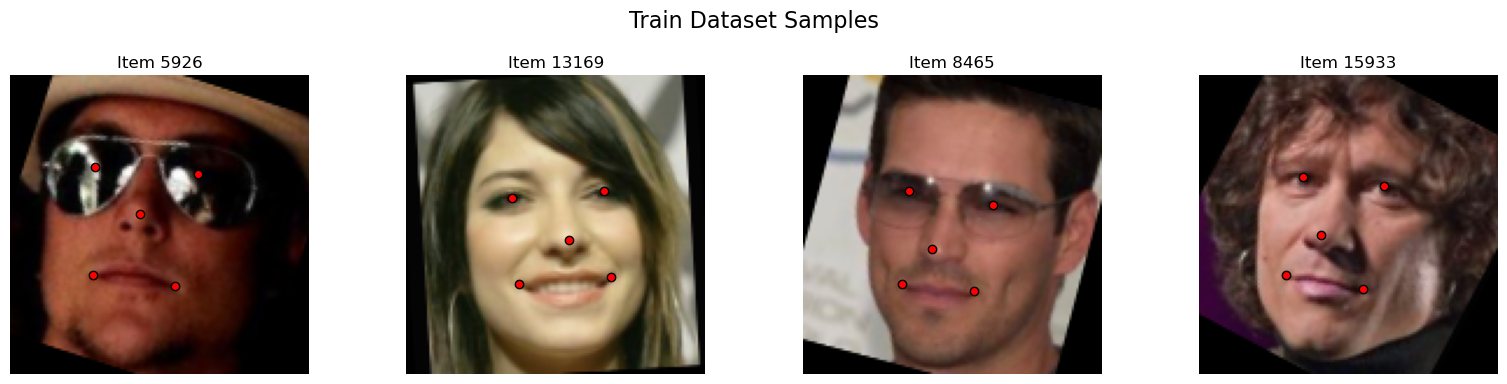

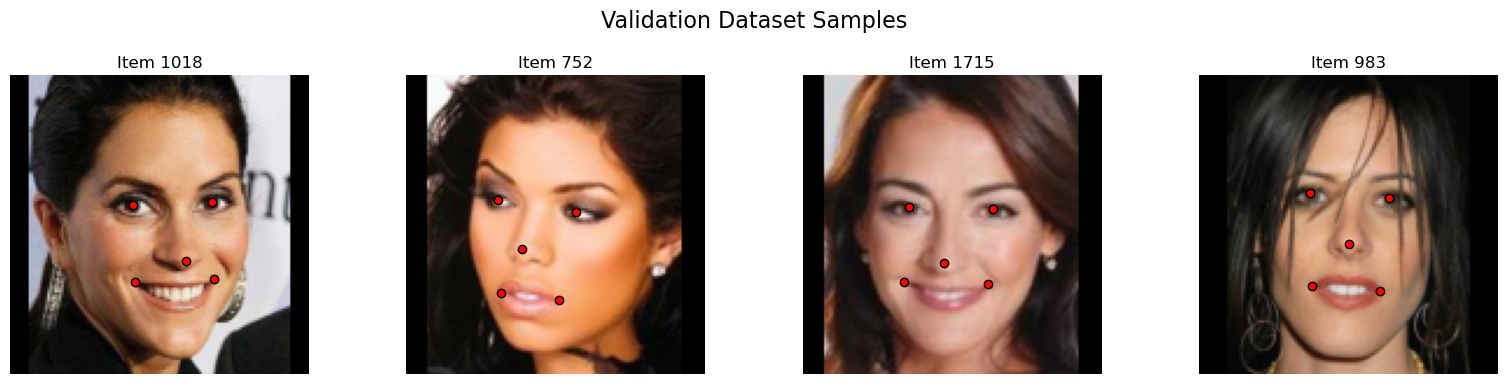

In [71]:
import matplotlib.pyplot as plt
import random
import cv2 # Import cv2 for image resizing

def visualize_dataset_item(image_tensor, keypoints_tensor, ax, title="Dataset Item Visualization"):
    """
    Visualizes an image from the dataset along with its keypoints on a given matplotlib axis.
    """
    # Denormalize the image for display
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()

    # Clip values to [0, 1] for proper image display
    image_display = np.clip(image_display, 0, 1)

    keypoint_names = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']
    num_keypoints = keypoints_tensor.shape[0]

    ax.imshow(image_display)
    ax.set_title(title)
    ax.axis('off')

    # Overlay all keypoints on the single image
    for i in range(num_keypoints):
        kp_array = keypoints_tensor[i].cpu().numpy() # Get keypoint array
        # Handle cases where keypoint might be [[x, y]] instead of [x, y]
        if kp_array.ndim > 1 and kp_array.shape[0] == 1: # If it's a 1x2 array
            x, y = kp_array.flatten() # Flatten to get [x, y]
        else:
            x, y = kp_array # Otherwise, unpack directly

        # Mark keypoint with a dot and add text label
        ax.plot(x, y, 'o', color='red', markersize=6, markeredgecolor='black', markeredgewidth=1)
        ax.text(x + 2, y + 2, "", color='white', fontsize=8,
                bbox=dict(facecolor='blue', alpha=0.6, edgecolor='none'))

def visualize_multiple_dataset_items(dataset, num_items=4, title="Dataset Items Visualization"):
    """
    Visualizes multiple images from a dataset in a grid.
    """
    fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_items):
        idx = random.randint(0, len(dataset) - 1)
        image, keypoints = dataset[idx]
        visualize_dataset_item(image, keypoints, axes[i], title=f"Item {idx}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize 4 random items from the training dataset
visualize_multiple_dataset_items(train_dataset, num_items=4, title="Train Dataset Samples")

# Visualize 4 random items from the validation dataset
visualize_multiple_dataset_items(val_dataset, num_items=4, title="Validation Dataset Samples")

## Архитектура Stacked Hourglass Network

In [43]:
import numpy as np

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for (x, y) in landmarks:
        hm = create_heatmap(image_shape, landmark=(x,y), sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

В разных вариантах пайплайна для распознавания лиц ключевые точки лица могут предсказываться сразу детектором (MTCNN, RetinaFace и прочие), а могут и отдельной моделью. В этом проекте рассматривается второй вариант. То есть, за детекцию ключевых точек будет отвечать отдельная модель.

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://img2018.cnblogs.com/blog/900393/201907/900393-20190722093153502-1808128161.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://curt-park.github.io/images/stacked_hourglass_networks/fig3.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок имеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Подготовка датасета для обучения

На этом этапе у вас уже должен быть готовый датасет на основе CelebA In A Wild.

В разметке CelebA всего 5 точек:

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**. Обязательно приведите примеры того, как работает ваш алгоритм.

# План заданий

По итогу, в этом блоке у вас следующие задачи:

*   Подготовить датасет, сохранить файл с оригинальными названиями изображений
*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Преобразовать точки лица в Heatmap'ы
*   Обучить Stacked Hourglass
*   Найти функцию, которая по предсказанным ключевым точкам выравнивает лица на картинке (face alignment)
*   Подготовить датасет с кропнутыми и выровненными лицами для следующего этапа

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

## Начинаем!

В оригинальной статье Stacked Hourglass Network for Human Pose Estimation на входе использовались изображения 256x256x3. На вход Hourglass блоков подавались тензоры 64x64x256. В принципе, для лиц, вероятно, не требуется такое большое изначальное разрешение, поэтому лица будем сжимать до 128х128х3. Но размерность внутри Hourglass блоков оставим прежней, потому что количество слоёв внутри блоков было подобрано под эту размерность, и она показала хорошие результаты.


In [45]:
class HourglassBlock(nn.Module):
    """Рекурсивный Hourglass Block как на схеме (при depth=5)"""
    def __init__(self, depth: int, channels: int):
        """
        Args:
            depth: Глубина hourglass (количество уровней downsampling)
            channels: Количество каналов на всех уровнях
        """
        super(HourglassBlock, self).__init__()
        self.depth = depth
        self.channels = channels

        # Блоки для нисходящего пути
        self.down_conv = ResidualBlock(channels, channels)
        self.pool = nn.MaxPool2d(2, stride=2)  # Уменьшение разрешения в 2 раза

        # Рекурсивный hourglass для следующего уровня (если это не самый нижний уровень)
        if depth > 1:
            self.hourglass = HourglassBlock(depth - 1, channels)
        else:
            # На самом нижнем уровне используем residual блоки вместо рекурсии
            self.hourglass = nn.Sequential(
                ResidualBlock(channels, channels),
                ResidualBlock(channels, channels)
            )

        # Блоки для восходящего пути
        self.up_conv = ResidualBlock(channels, channels)

        # Skip connection: residual блок, через который проходит skip connection
        self.skip_connection = ResidualBlock(channels, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход через hourglass block

        Args:
            x: Входной тензор размером [batch, channels, height, width]
               Пример: [16, 256, 64, 64]

        Returns:
            Выходной тензор того же размера, что и входной
            [batch, channels, height, width]
        """
        # =================== НИСХОДЯЩИЙ ПУТЬ ===================
        # Сохраняем признаки для skip connection
        skip = self.skip_connection(x)  # [B, C, H, W] -> [B, C, H, W]

        # Downsampling
        out = self.down_conv(x)          # [B, C, H, W] -> [B, C, H, W]
        out = self.pool(out)             # [B, C, H, W] -> [B, C, H/2, W/2]

        # =================== РЕКУРСИВНАЯ ОБРАБОТКА ===================
        # Обработка на более низком разрешении
        out = self.hourglass(out)        # [B, C, H/2, W/2] -> [B, C, H/2, W/2]

        # =================== ВОСХОДЯЩИЙ ПУТЬ ===================
        out = self.up_conv(out)          # [B, C, H/2, W/2] -> [B, C, H/2, W/2]

        # Upsampling (nearest neighbor для сохранения значений)
        out = F.interpolate(out, scale_factor=2, mode='nearest')  # [B, C, H/2, W/2] -> [B, C, H, W]

        # =================== SKIP CONNECTION ===================
        # Суммируем с сохраненными признаками (элементное сложение)
        out = out + skip                 # [B, C, H, W] + [B, C, H, W] -> [B, C, H, W]

        # Финальный residual блок
        out = ResidualBlock(self.channels, self.channels)(out)

        return out


Stacked Hourglass Network - это начальная предобработка изображения, чтобы привести его к размерности 64x64x256, передача его в Hourglass блоки, генерация heatmaps после каждого блока и агрегация этих heatmaps

In [46]:
class FacialHourglassNet(nn.Module):
    """
    Stacked Hourglass Network для детекции 5 ключевых точек лица
    Вход: 128×128×3 (RGB изображение лица)
    Выход: 5 heatmaps 64×64 (по одному на каждую точку) + координаты
    """
    def __init__(self, num_stacks=2, num_keypoints=5):
        super(FacialHourglassNet, self).__init__()

        self.num_stacks = num_stacks
        self.num_keypoints = num_keypoints

        # =================== ПРЕДОБРАБОТКА (FRONT-END) ===================
        # Преобразуем 128×128×3 → 64×64×256
        self.frontend = nn.Sequential(
            # Conv 3×3 вместо 7×7 для маленького изображения
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # MaxPool для уменьшения разрешения (сохраняет важные признаки)
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128×128 → 64×64

            # Первый residual блок с увеличением каналов
            ResidualBlock(64, 128),

            # Второй residual блок с увеличением до 256 каналов
            ResidualBlock(128, 256),

            # Финальная проекция в 256 каналов
            nn.Conv2d(256, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # =================== HOURGLASS БЛОКИ ===================
        # Создаем несколько Hourglass блоков
        self.hourglasses = nn.ModuleList([
            HourglassBlock(depth=5, channels=256)
            for _ in range(num_stacks)
        ])

        # =================== ПРЕДСКАЗАНИЯ HEATMAPS ===================
        # Каждый Hourglass имеет свой head для предсказания heatmaps
        self.heatmap_heads = nn.ModuleList([
            nn.Sequential(
                # 1. Свертка для подготовки признаков
                nn.Conv2d(256, 256, kernel_size=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),

                # 2. Финальная свертка на 5 каналов (по одному на точку)
                nn.Conv2d(256, num_keypoints, kernel_size=1),
                # НЕ добавляем активацию здесь - используем отдельно для heatmaps
            )
            for _ in range(num_stacks)
        ])

        # =================== МЕХАНИЗМЫ ОБЪЕДИНЕНИЯ ===================
        # Между hourglass блоками дообрабатываем признаки
        self.postprocess_blocks = nn.ModuleList([
            nn.Sequential(
                # Дополнительная обработка
                nn.Conv2d(256, 256, kernel_size=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            )
            for _ in range(num_stacks - 1)  # Для всех кроме последнего
        ])

        # Реинтеграция хитмапов (5 -> 256)
        self.postprocess_heatmaps = nn.ModuleList([
            nn.Sequential(
                # Дополнительная обработка
                nn.Conv2d(num_keypoints, 256, kernel_size=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True)
            )
            for _ in range(num_stacks - 1)  # Для всех кроме последнего
        ])

        # =================== ДОПОЛНИТЕЛЬНЫЕ СЛОИ ===================
        # BatchNorm для стабилизации heatmaps
        self.heatmap_bn = nn.BatchNorm2d(num_keypoints)

    def forward(self, x):
        """
        Прямой проход через всю сеть

        Args:
            x: [batch_size, 3, 128, 128] - изображения лиц

        Returns:
            all_heatmaps: Список heatmaps от каждого hourglass [batch, 5, 64, 64]
            coords: Координаты точек от последнего hourglass [batch, 5, 2]
        """

        # ========== ШАГ 1: ПРЕДОБРАБОТКА ==========
        # [B, 3, 128, 128] → [B, 256, 64, 64]
        features = self.frontend(x)

        # Сохраняем оригинальные признаки для residual connections
        preceeding_features = features.clone()

        # ========== ШАГ 2: ПОСЛЕДОВАТЕЛЬНЫЕ HOURGLASS ==========
        all_heatmaps = []

        for i in range(self.num_stacks):
            # Пропускаем через hourglass
            # [B, 256, 64, 64] → [B, 256, 64, 64]
            features = self.hourglasses[i](features)

            # Предсказываем heatmaps
            # [B, 256, 64, 64] → [B, 5, 64, 64]
            heatmaps = self.heatmap_heads[i](features)
            heatmaps = self.heatmap_bn(heatmaps)  # Стабилизируем значения

            # Применяем сигмоиду для получения вероятностей (0-1)
            heatmaps = torch.sigmoid(heatmaps)

            # Сохраняем heatmaps
            all_heatmaps.append(heatmaps)

            # ========== ШАГ 3: ПОДГОТОВКА К СЛЕДУЮЩЕМУ HOURGLASS ==========
            if i < self.num_stacks - 1:  # Если это не последний hourglass
                # Проводим фичи через блок дообработки
                # [B, 256, 64, 64] → [B, 256, 64, 64]
                features = self.postprocess_blocks[i](features)

                # Трансформируем heatmaps в пространство признаков
                heatmaps_features = self.postprocess_heatmaps[i](heatmaps)  # [B, 256, 64, 64]

                # Добавляем residual connection (помогает градиентам)
                features = features + preceeding_features + heatmaps_features

                # Сохраняем фичи для скип коннекшна следующего блока
                preceeding_features = features.clone()

        return all_heatmaps

    def get_expected_coords(self, heatmaps):
        """
        Вычисляет математическое ожидание координат из heatmaps
        (более гладкий и дифференцируемый метод)
        """
        batch_size, num_points, h, w = heatmaps.shape

        # Создаем сетку координат для heatmap
        y_grid, x_grid = torch.meshgrid(
            torch.arange(h, device=heatmaps.device, dtype=torch.float32),
            torch.arange(w, device=heatmaps.device, dtype=torch.float32),
            indexing='ij'
        )

        # Нормализуем heatmaps (сумма = 1 для каждой точки)
        heatmaps_norm = heatmaps / (heatmaps.sum(dim=(2, 3), keepdim=True) + 1e-8)

        coords = torch.zeros(batch_size, num_points, 2, device=heatmaps.device)

        for b in range(batch_size):
            for p in range(num_points):
                # Математическое ожидание по x и y
                exp_x = (heatmaps_norm[b, p] * x_grid).sum()
                exp_y = (heatmaps_norm[b, p] * y_grid).sum()

                # Масштабируем к оригинальному разрешению
                coords[b, p, 0] = exp_x * 2.0  # x (64 → 128)
                coords[b, p, 1] = exp_y * 2.0  # y (64 → 128)

        return coords

    def visualize_heatmaps(self, image, heatmaps, index=0):
        """
        Визуализация heatmaps для отладки
        """
        import matplotlib.pyplot as plt

        # Берем первый батч
        img = image[index].cpu().detach().permute(1, 2, 0).numpy()
        hms = heatmaps[-1][index].cpu().detach()  # Берем последний stack

        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Оригинальное изображение
        axes[0, 0].imshow(img)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        # Heatmaps для каждой точки
        point_names = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']

        for i in range(5):
            ax = axes[(i+1)//3, (i+1)%3]
            hm = hms[i].numpy()

            # Интерполируем heatmap до размера изображения
            import cv2
            hm_resized = cv2.resize(hm, (128, 128))

            ax.imshow(img, alpha=0.5)
            ax.imshow(hm_resized, cmap='jet', alpha=0.5)
            ax.set_title(point_names[i])
            ax.axis('off')

            # Добавляем точку с максимальной вероятностью
            y, x = np.unravel_index(np.argmax(hm), hm.shape)
            ax.plot(x*2, y*2, 'go', markersize=8)  # Масштабируем координаты

        plt.tight_layout()
        plt.show()

Теперь, когда у нас есть все блоки для сети, надо сделать датасет